### Libraries

In [1]:
import glob
import os
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
import texthero as hero
from texthero import preprocessing
sb.set() # set the default Seaborn style for graphics

### Chunking CSV to upload onto GitHub

import pandas as pd

chunk_size = 55000
batch_no = 1

for chunk in pd.read_csv('221100_DayZ.csv', chunksize=chunk_size):
    #chunk.to_csv('221100_DayZ' + str(batch_no) + '.csv', index=False)
    #batch_no +=1

### Dataset

In [2]:
steamData = pd.read_csv('steam_data/steam.csv')
steamSupportInfo = pd.read_csv('steam_data/steam_support_info.csv')
steamChart = pd.read_csv('steam_data/steamCharts.csv')
steamSpyTagData = pd.read_csv('steam_data/steamspy_tag_data.csv')
steamGames = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "steam_data/steam_games/steam_games*.csv"))))
steamMediaData = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "steam_data/steam_media_data/steam_media_data*.csv"))))
steamRequirements = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "steam_data/steam_requirements/steam_requirements*.csv"))))
steamDescription = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "steam_data/steam_description/steam_description*.csv"))))

#game reviews
steam_HalfOfTheGameReviews = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "steam_data/steam_reviews/steam_review_*.csv"))))
files = glob.glob("steam_data/steam_reviews" + '**/**' + "/*.csv")
steamReviews_fromFolder = pd.concat([pd.read_csv(f) for f in files ])
steamReviewsDF = [steam_HalfOfTheGameReviews, steamReviews_fromFolder]
steamCombinedReviews = pd.concat(steamReviewsDF)

C:\Users\Pyae Pyae\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3437: DtypeWarning: Columns (23) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\Pyae Pyae\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3437: DtypeWarning: Columns (1,23) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\Pyae Pyae\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3357: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
C:\Users\Pyae Pyae\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3357: DtypeWarning: Columns (23) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


### Cleaning the Dataset

In [3]:
#rename for easier identification
steamGames = steamGames.rename(columns={"name": "title"})

#create a custom cleaning pipeline
custom_pipeline = [preprocessing.fillna
                   , preprocessing.lowercase
                   , preprocessing.remove_punctuation
                   , preprocessing.remove_diacritics
                   , preprocessing.remove_whitespace]

steamCombinedReviews['title'] = hero.clean(steamCombinedReviews['title'], pipeline = custom_pipeline)
steamGames['title'] = hero.clean(steamGames['title'], pipeline = custom_pipeline)

##### Getting title, genre and release date

In [4]:
#getting title and genre from steamGames df
steamGames_Title_Genre = steamGames[['title', 'genre', 'release_date']]

#getting title and review from steamCombinedReviews df
steamCombinedReviews_Title_Reviews = steamCombinedReviews[['title', 'review']]

##### matching title in steamGames with steamCombinedReview

In [5]:
matchTitle = steamGames_Title_Genre.title.isin(steamCombinedReviews_Title_Reviews.title)
steamMatchTitle = steamGames_Title_Genre[matchTitle]

##### dropping duplicate values

In [6]:
steamUniqueTitle = steamMatchTitle.drop_duplicates(['title'])
steamUniqueTitle = steamUniqueTitle.reset_index(drop=True)

steamUniqueTitle
nan_value = float("NaN")
steamUniqueTitle.replace("", nan_value, inplace=True)
steamUniqueTitle.info()

steamUniqueTitle.dropna(subset = ["genre"], inplace=True)
steamUniqueTitle
#steamUniqueTitle.to_excel("output.xlsx")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131 entries, 0 to 130
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         130 non-null    object
 1   genre         130 non-null    object
 2   release_date  127 non-null    object
dtypes: object(3)
memory usage: 3.2+ KB


,title,genre,release_date
0,playerunknown s battlegrounds,"Action,Adventure,Massively Multiplayer","Dec 21, 2017"
1,battletech,"Action,Adventure,Strategy","Apr 24, 2018"
2,human fall flat,"Adventure,Indie","Jul 22, 2016"
3,they are billions,"Strategy,Early Access","Dec 12, 2017"
4,counter strike source,Action,"Nov 1, 2004"
...,...,...,...
126,atlas,"Action,Adventure,Massively Multiplayer,RPG,Ear...","Dec 22, 2018"
127,metro exodus,Action,"Feb 14, 2019"
128,transport fever 2,"Simulation,Strategy",Q4 2019
129,halo the master chief collection,Action,Coming Soon


In [7]:
#steamUniqueTitle.to_excel("output.xlsx")

##### remove Early Acess, Massively Multiplayer and Free to Play values from genre column

In [8]:
steamUniqueTitle['genre'] = steamUniqueTitle.genre.str.replace(',Early Access?', '')
steamUniqueTitle['genre'] = steamUniqueTitle.genre.str.replace(',Massively Multiplayer?', '')
steamUniqueTitle['genre'] = steamUniqueTitle.genre.str.replace('Massively Multiplayer,?', '')
steamUniqueTitle['genre'] = steamUniqueTitle.genre.str.replace(',Free to Play?', '')
steamUniqueTitle['genre'] = steamUniqueTitle.genre.str.replace('Free to Play,?', '')

<ipython-input-8-1b6a5137f3ce>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  steamUniqueTitle['genre'] = steamUniqueTitle.genre.str.replace(',Early Access?', '')
<ipython-input-8-1b6a5137f3ce>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  steamUniqueTitle['genre'] = steamUniqueTitle.genre.str.replace(',Massively Multiplayer?', '')
<ipython-input-8-1b6a5137f3ce>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  steamUniqueTitle['genre'] = steamUniqueTitle.genre.str.replace('Massively Multiplayer,?', '')
<ipython-input-8-1b6a5137f3ce>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  steamUniqueTitle['genre'] = steamUniqueTitle.genre.str.replace(',Free to Play?', '')
<ipython-input-8-1b6a5137f3ce>:5: FutureWarning: The default value of regex will change from True to False in a future ver

##### remove Coming Soon values from release_date column

In [9]:
steamUniqueTitle['release_date'] = steamUniqueTitle.release_date.str.replace('Coming Soon' , '')

##### split genre into 6 columns

In [10]:
steamUniqueTitle[['genre1', 'genre2', 'genre3','genre4','genre5','genre6']] = steamUniqueTitle['genre'].str.split(',', expand=True)

##### dropping genre, title, and release date columns to get the total count of genre

In [11]:
steamGenreCount = steamUniqueTitle.drop(columns=['genre','title', 'release_date'])

##### reset index and rename the column

In [12]:
steamGenreGraph = steamGenreCount.stack().value_counts().reset_index()
steamGenreGraph.columns = ['genre','count']

##### graph to see which genre is most popular 

<AxesSubplot:xlabel='genre', ylabel='count'>

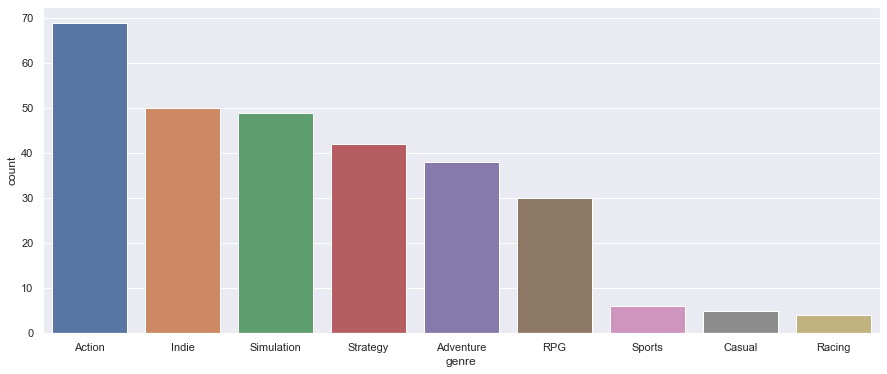

In [13]:
fig_dims = (15, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sb.barplot(x="genre", y="count", data=steamGenreGraph, ax=ax)

we can see that most popular genres are action, indie and simulation

In [16]:
# storing first 3 letters of name as username
steamGenre_Date = steamUniqueTitle
steamGenre_Date['year'] = steamGenre_Date['release_date'].str.slice(-4)
#steamGenre_Date = steamUniqueTitle.drop(columns=['title', 'genre1', 'genre2', 'genre3','genre4','genre5','genre6'])
steamGenre_Date = steamUniqueTitle.drop(columns=['title', 'genre','release_date'])
steamGenre_Date

,genre1,genre2,genre3,genre4,genre5,genre6,year
0,Action,Adventure,None,None,None,None,2017
1,Action,Adventure,Strategy,None,None,None,2018
2,Adventure,Indie,None,None,None,None,2016
3,Strategy,None,None,None,None,None,2017
4,Action,None,None,None,None,None,2004
...,...,...,...,...,...,...,...
126,Action,Adventure,RPG,None,None,None,2018
127,Action,None,None,None,None,None,2019
128,Simulation,Strategy,None,None,None,None,2019
129,Action,None,None,None,None,None,


In [26]:
#options = ['Action','Indie','Simulation']
options = ['Action']
test = steamGenre_Date.loc[steamGenre_Date['genre1'].isin(options) | steamGenre_Date['genre2'].isin(options) | steamGenre_Date['genre3'].isin(options)
                           | steamGenre_Date['genre4'].isin(options) | steamGenre_Date['genre5'].isin(options) | steamGenre_Date['genre6'].isin(options)]


test

,genre1,genre2,genre3,genre4,genre5,genre6,year
0,Action,Adventure,None,None,None,None,2017
1,Action,Adventure,Strategy,None,None,None,2018
4,Action,None,None,None,None,None,2004
5,Action,Adventure,RPG,None,None,None,2017
8,Action,Simulation,Strategy,None,None,None,2014
...,...,...,...,...,...,...,...
121,Action,Adventure,None,None,None,None,2015
123,Action,None,None,None,None,None,2000
126,Action,Adventure,RPG,None,None,None,2018
127,Action,None,None,None,None,None,2019


In [29]:
test.dtypes

genre1    object
genre2    object
genre3    object
genre4    object
genre5    object
genre6    object
year      object
dtype: object

In [25]:
test

,genre1,genre2,genre3,genre4,genre5,genre6,year
0,Action,Adventure,None,None,None,None,2017
1,Action,Adventure,Strategy,None,None,None,2018
4,Action,None,None,None,None,None,2004
5,Action,Adventure,RPG,None,None,None,2017
8,Action,Simulation,Strategy,None,None,None,2014
...,...,...,...,...,...,...,...
121,Action,Adventure,None,None,None,None,2015
123,Action,None,None,None,None,None,2000
126,Action,Adventure,RPG,None,None,None,2018
127,Action,None,None,None,None,None,2019


In [30]:
test["year"] = pd.to_numeric(test["year"])
#test["year"] = test["year"].astype(str).astype(int)

<ipython-input-30-9f3bffe6c8a0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["year"] = pd.to_numeric(test["year"])


In [31]:
test["year"] = test["year"].fillna(0.0).astype(int)

<ipython-input-31-bb7be34a852b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["year"] = test["year"].fillna(0.0).astype(int)


In [32]:
# Get names of indexes for which column Age has value 30
indexNames =test[ test['year'] == 0 ].index
# Delete these row indexes from dataFrame
test.drop(indexNames , inplace=True)

C:\Users\Pyae Pyae\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [ ]:
#sb.histplot(data=rslt_df, x="year", hue="genre", multiple="dodge")

In [33]:
test

,genre1,genre2,genre3,genre4,genre5,genre6,year
0,Action,Adventure,None,None,None,None,2017
1,Action,Adventure,Strategy,None,None,None,2018
4,Action,None,None,None,None,None,2004
5,Action,Adventure,RPG,None,None,None,2017
8,Action,Simulation,Strategy,None,None,None,2014
...,...,...,...,...,...,...,...
119,Action,Adventure,None,None,None,None,2015
121,Action,Adventure,None,None,None,None,2015
123,Action,None,None,None,None,None,2000
126,Action,Adventure,RPG,None,None,None,2018
